In [722]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_absolute_percentage_error
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from yellowbrick.contrib.wrapper import wrap
from yellowbrick.regressor import ResidualsPlot

# Reading data

In [723]:
df = pd.read_csv("properties_v2.csv", sep=",")

In [724]:
df['neighbourhood'] = df['neighbourhood'].astype(str)

In [725]:
bool_cols = [col for col in df if 
               df[col].dropna().value_counts().index.isin([0,1]).all()]

In [726]:
# numerical_features = ["area", "rooms", "bathrooms", "garages"]
numerical_features = ["area", "bathrooms", "garages"]
categorical_features = ["neighbourhood"]
binary_features = bool_cols
target = "price"

In [727]:
df.isnull().sum()[:10]

index        0
id           0
url          0
header       0
address      0
area         0
rooms        0
bathrooms    0
garages      0
price        0
dtype: int64

Condominio muito missing:
Opcao 1a: Remover a coluna
Opcao 1b: Remover as observacoes faltantes
Opcao 2: Imputation (completar os valores faltantes)
Opcao 3: Usar mesmo assim

In [728]:
df = df.dropna(subset = ["area", "rooms", "bathrooms", "garages", "price"])

# Data pipeline

In [729]:
numerical_features

['area', 'bathrooms', 'garages']

In [730]:
scaler = MinMaxScaler()
data_pipeline = ColumnTransformer([("numerical", scaler, numerical_features)], 
                                  remainder="passthrough")

In [731]:
X = df[numerical_features + categorical_features + binary_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [732]:
data_pipeline.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', MinMaxScaler(),
                                 ['area', 'bathrooms', 'garages'])])

In [733]:
X_train_transformed = data_pipeline.transform(X_train)
X_test_transformed = data_pipeline.transform(X_test)

In [734]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=numerical_features+categorical_features+binary_features)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=numerical_features+categorical_features+binary_features)

# Feature selection

In [735]:
selector = SelectKBest(score_func=mutual_info_regression, k="all")
selector.fit(X_train_transformed[numerical_features+binary_features], y_train)

SelectKBest(k='all',
            score_func=<function mutual_info_regression at 0x000001FC0025A280>)

In [736]:
pd.DataFrame(zip(numerical_features + binary_features, selector.scores_), columns=["feature", "score"]).sort_values("score", ascending=False).head(10)

feature     score
0                 area  0.655390
1            bathrooms  0.342997
2              garages  0.275177
16       Churrasqueira  0.039019
67             Piscina  0.028803
52           Interfone  0.027482
9      Ar-condicionado  0.025507
3             Academia  0.024310
11  Armário na cozinha  0.022517
62           Mobiliado  0.021273

# Fitting model

## Baseline - linear regression

In [737]:
scaler = MinMaxScaler()
ohe = OneHotEncoder()
data_pipeline = ColumnTransformer([("numerical", scaler, numerical_features), 
                                   ("categorical", ohe, categorical_features)], 
                                  remainder="passthrough")

In [738]:
X = df[numerical_features + categorical_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [739]:
data_pipeline.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', MinMaxScaler(),
                                 ['area', 'bathrooms', 'garages']),
                                ('categorical', OneHotEncoder(),
                                 ['neighbourhood'])])

In [740]:
X_train_transformed = data_pipeline.transform(X_train)
X_test_transformed = data_pipeline.transform(X_test)

In [741]:
model = LinearRegression()

In [742]:
model.fit(X_train_transformed, y_train)

LinearRegression()

In [743]:
y_pred = model.predict(X_test_transformed)
y_pred_train = model.predict(X_train_transformed)

In [744]:
mape_lr = mean_absolute_percentage_error(y_test, y_pred)

In [745]:
r2_lr = r2_score(y_test, y_pred)

In [746]:
mape_lr_train = mean_absolute_percentage_error(y_train, y_pred_train)

In [747]:
r2_lr_train = r2_score(y_train, y_pred_train)

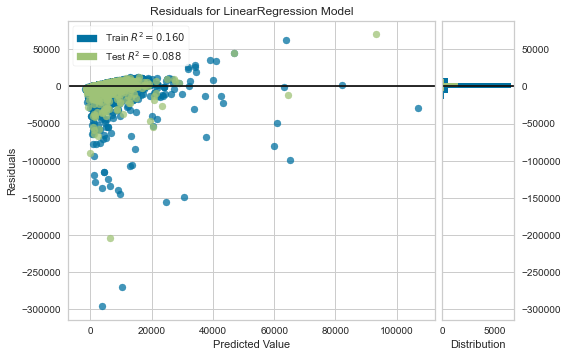

<AxesSubplot:title={'center':'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [748]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train_transformed, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_transformed, y_test)  # Evaluate the model on the test data
visualizer.show()         

## Random Forest

In [749]:
model = RandomForestRegressor(max_depth=4)
model.fit(X_train_transformed, y_train)

RandomForestRegressor(max_depth=4)

In [750]:
y_pred = model.predict(X_test_transformed)
y_pred_train = model.predict(X_train_transformed)

In [751]:
mape_rf = mean_absolute_percentage_error(y_test, y_pred)

In [752]:
r2_rf = r2_score(y_test, y_pred)

In [753]:
mape_rf_train = mean_absolute_percentage_error(y_train, y_pred_train)

In [754]:
r2_rf_train = r2_score(y_train, y_pred_train)

In [755]:
y_test.shape

(1980,)

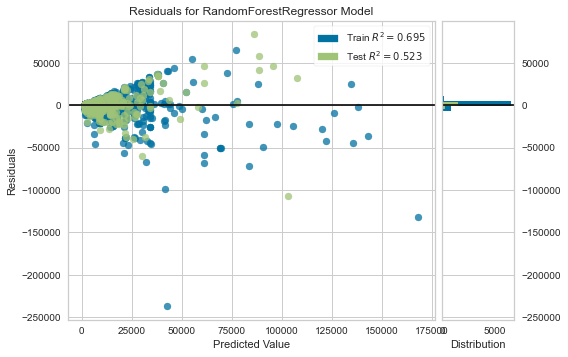

<AxesSubplot:title={'center':'Residuals for RandomForestRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [756]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train_transformed, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_transformed, y_test)  # Evaluate the model on the test data
visualizer.show()         

# XGboost

In [757]:
model = XGBRegressor(max_depth=4)
model.fit(X_train_transformed, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=4,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [758]:
y_pred = model.predict(X_test_transformed)
y_pred_train = model.predict(X_train_transformed)

In [759]:
mape_xgboost = mean_absolute_percentage_error(y_test, y_pred)

In [760]:
r2_xgboost = r2_score(y_test, y_pred)

In [761]:
mape_xgboost_train = mean_absolute_percentage_error(y_train, y_pred_train)

In [762]:
r2_xgboost_train = r2_score(y_train, y_pred_train)

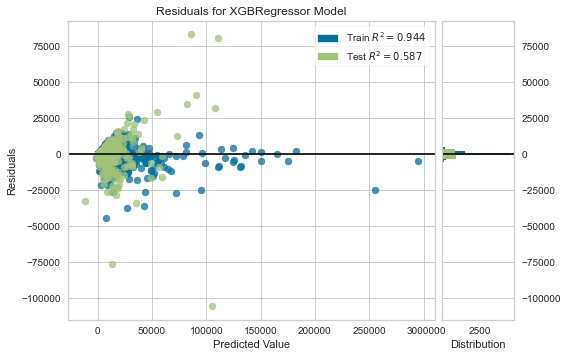

<AxesSubplot:title={'center':'Residuals for XGBRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [763]:
visualizer = ResidualsPlot(model)

visualizer.fit(X_train_transformed, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_transformed, y_test)  # Evaluate the model on the test data
visualizer.show()         

# Catboost

In [764]:
scaler = MinMaxScaler()
data_pipeline = ColumnTransformer([("numerical", scaler, numerical_features)], 
                                  remainder="passthrough")

In [765]:
X = df[numerical_features + categorical_features]
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)

In [766]:
data_pipeline.fit(X_train)

ColumnTransformer(remainder='passthrough',
                  transformers=[('numerical', MinMaxScaler(),
                                 ['area', 'bathrooms', 'garages'])])

In [767]:
X_train_transformed = data_pipeline.transform(X_train)
X_test_transformed = data_pipeline.transform(X_test)

In [768]:
X_train_transformed = pd.DataFrame(X_train_transformed, columns=numerical_features+categorical_features)
X_test_transformed = pd.DataFrame(X_test_transformed, columns=numerical_features+categorical_features)

In [769]:
model = CatBoostRegressor(cat_features=["neighbourhood"])
model.fit(X_train_transformed, y_train, eval_set=(X_test_transformed, y_test), verbose=False)

In [770]:
y_pred = model.predict(X_test_transformed)
y_pred_train = model.predict(X_train_transformed)

In [771]:
mape_catboost = mean_absolute_percentage_error(y_test, y_pred)

In [772]:
r2_catboost = r2_score(y_test, y_pred)

In [773]:
mape_catboost_train = mean_absolute_percentage_error(y_train, y_pred_train)

In [774]:
r2_catboost_train = r2_score(y_train, y_pred_train)

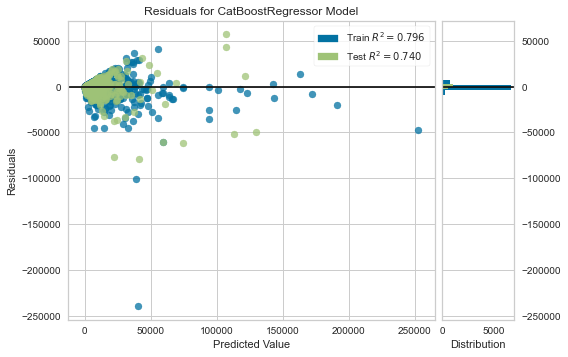

<AxesSubplot:title={'center':'Residuals for CatBoostRegressor Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [775]:
wrapped_model = wrap(model)
visualizer = ResidualsPlot(wrapped_model)

visualizer.fit(X_train_transformed, y_train)  # Fit the training data to the visualizer
visualizer.score(X_test_transformed, y_test)  # Evaluate the model on the test data
visualizer.show()         

In [776]:
### https://catboost.ai/

# Juntando

In [777]:
mapes = [mape_lr, mape_rf, mape_xgboost, mape_catboost]
r2s = [r2_lr, r2_rf, r2_xgboost, r2_catboost]
mapes_train = [mape_lr_train, mape_rf_train, mape_xgboost_train, mape_catboost_train]
r2s_train = [r2_lr_train, r2_rf_train, r2_xgboost_train, r2_catboost_train]

In [778]:
results = pd.DataFrame(zip(mapes, r2s, mapes_train, r2s_train), index=["linear_regression", "random_forest", "xgboost", "catboost"],
             columns=["mape", "r2", "mape_train", "r2_train"])

In [779]:
results.to_csv("resultados.csv")